In [ ]:
from torchvision import datasets, transforms
import random
base_transform = transforms.ToTensor()

base_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=base_transform
)

base_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=base_transform
)


In [ ]:
class TexturedColorMNIST:
    def __init__(self, bias_prob=0.95):
        self.bias_prob = bias_prob

    def __call__(self, img, label):
        img = img.squeeze(0)  # [28,28]
        digit_mask = img > 0.2
        bg_mask = ~digit_mask

        base_color = digit_colors[label]
        base_color = base_color.view(3,1,1)

        # Foreground texture
        grayscale = img.unsqueeze(0)  # [1,28,28]
        color_component = base_color * 0.6
        shape_component = grayscale.repeat(3,1,1) * 0.6
        foreground = color_component + shape_component
        # Background texture
        bg_texture = noise = torch.randn(1, 28, 28) * 0.3
        background = base_color * 0.15 + base_color * noise * 0.5
        # Combine
        rgb = torch.zeros(3,28,28)
        rgb[:, digit_mask] = foreground[:, digit_mask]
        rgb[:, bg_mask] = background[:, bg_mask]

        return rgb.clamp(0,1)


In [ ]:
import torch
digit_colors = torch.tensor([
    [1., 0., 0.],  # Red for 0
    [0., 1., 0.],  # Green for 1
    [0., 0., 1.],  # Blue for 2
    [1., 1., 0.],  # Yellow for 3
    [0., 1., 1.],  # Cyan for 4
    [1., 0., 1.],  # Magenta for 5
    [0.5, 0.5, 0.], # Olive for 6
    [0., 0.5, 0.5], # Teal for 7
    [0.5, 0., 0.5], # Purple for 8
    [0.5, 0.5, 0.5]  # Gray for 9
])

In [ ]:
from torch.utils.data import Dataset

class ColoredMNIST(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist = mnist_dataset
        self.colorizer = TexturedColorMNIST()

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]          # grayscale MNIST
        img = self.colorizer(img, label)     # apply your texture+color
        return img, label


In [ ]:
train_easy = ColoredMNIST(base_train)

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

def show_100_random(dataset, cols=10):
    """
    Displays 100 random images from a dataset.
    Works for both grayscale [1,H,W] and RGB [3,H,W].
    """
    indices = random.sample(range(len(dataset)), min(100, len(dataset)))
    images = [dataset[i][0] for i in indices]

    rows = len(images) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))

    for i, ax in enumerate(axes.flatten()):
        img = images[i]
        if img.shape[0] == 1:
            ax.imshow(img.squeeze(), cmap="gray")
        else:
            ax.imshow(img.permute(1, 2, 0))
        ax.axis("off")

    plt.suptitle(f"100 Random Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

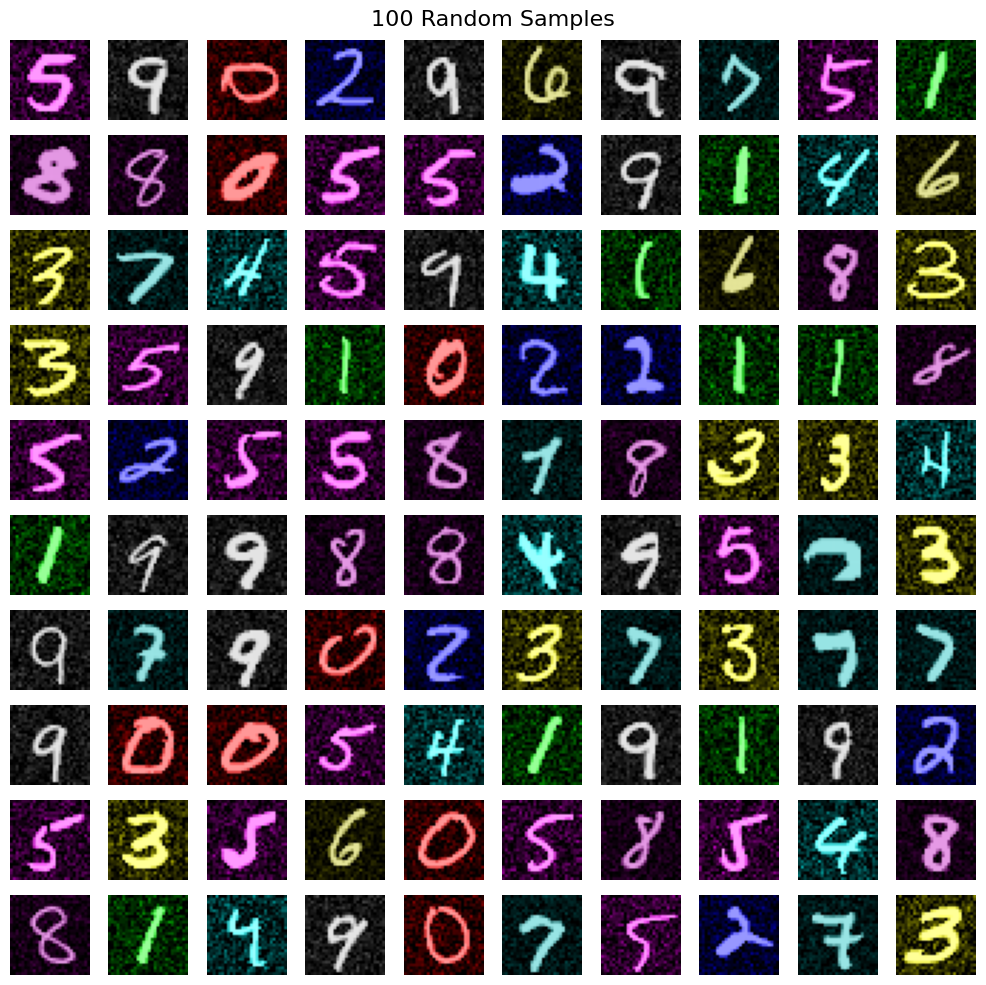

In [ ]:
show_100_random(train_easy)